In [1]:
!wget -r -N -c -np https://physionet.org/files/ludb/1.0.0/


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Length: 116 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v4’

physionet.org/files 100%[===================>]     116  --.-KB/s    in 0s      

2020-12-10 05:36:01 (17.1 MB/s) - ‘physionet.org/files/ludb/1.0.0/67.atr_v4’ saved [116/116]

--2020-12-10 05:36:01--  https://physionet.org/files/ludb/1.0.0/67.atr_v5
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 116 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v5’

physionet.org/files 100%[===================>]     116  --.-KB/s    in 0s      

2020-12-10 05:36:01 (22.3 MB/s) - ‘physionet.org/files/ludb/1.0.0/67.atr_v5’ saved [116/116]

--2020-12-10 05:36:01--  https://physionet.org/files/ludb/1.0.0/67.atr_v6
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 110 [text/plain]
Saving to: ‘physionet.org/files/ludb/1.0.0/67.atr_v6’

physionet.org/files 100%[=======

In [1]:
!pip install wfdb

In [5]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import re
import wfdb
from wfdb import processing

data_dir = Path('/content/physionet.org/files/ludb/1.0.0')

num_records = 200
records = []
for i in range(1,num_records+1):
    record = wfdb.io.rdrecord(f'{data_dir}/{i}')
    age = 99 if record.comments[0][7:] == '>89' else int(record.comments[0][7:])
    data = {'id': i,
            'age(10)' : age //10 * 10, 
            'sex':record.comments[1][-1],
            'dignosis':record.comments[3:]}
    cols = ['i', 'ii',  'iii',  'avr',  'avl',  'avf',  'v1',  'v2',  'v3',  'v4',  'v5',  'v6']
    for col, j in zip(cols, range(12)):
        ann = wfdb.rdann(f'{data_dir}/{i}', f'atr_{col}')
        data[col] = {'signal':record.p_signal[:, j], 'anno': ann.__dict__['symbol'], 'anno_idx': ann.__dict__['sample']}
    records.append(data)

In [6]:
wave_length = 600
# os.makedirs(f'/content/MyDrive/Colab Notebooks/physionet.org/{lead}' + f'/{wave_length}/')



for i in range(20):
  print(f'{i}/20')
  a = 0

  for lead in cols:
#    os.makedirs(f'/content/drive/MyDrive/Colab Notebooks/physionet.org/{lead}' + f'/{wave_length}/')

    pqrst_label = np.array(records[i][lead]['anno'])
    pqrst_point = np.array(records[i][lead]['anno_idx'])
    lead_signal = records[i][lead]['signal']

    start_points = np.where(np.array(pqrst_label)=='p')[0]-1 

      # qrs파('N')를 시작점으로 모든 segment를 자르자.
    for j,start_point in enumerate(start_points):
        start_index = pqrst_point[start_point]
        seg_signal = lead_signal[start_index:start_index+wave_length] 

        pqrst_index = pqrst_point[(pqrst_point>=start_index)&(pqrst_point<start_index+wave_length)] 

        # segment 안에 존재하는 pqrst list
        seg_labels = pqrst_label[np.isin(pqrst_point,pqrst_index)] 
        # 해당 pqrst의 segment상 인덱스
        seg_labels_index = pqrst_index - start_index

        unet_label_list = list()
        unet_label_list.append(seg_signal)
        for pqrst in ['p','N','t']:
            # 'p','N','t'의 인덱스
            pqrst_peak = np.where(seg_labels==pqrst)[0]

            # seg_labels에서 onset offset 인덱스

            onset_pqrst = pqrst_peak-1
            offset_pqrst = pqrst_peak+1

            mask = np.zeros(wave_length) 
            for onset,offset in zip(onset_pqrst,offset_pqrst[:len(onset_pqrst)]):
                try:
                    onset_index = seg_labels_index[onset]
                    offset_index = seg_labels_index[offset]
                    mask[onset_index:offset_index] =1
                except IndexError:
                    pass

            unet_label_list.append(mask)
        
        if unet_label_list[-1].sum()!=0:
            # T가 존재해야지만 저장한다.
          last_mask = np.ones(wave_length)-(unet_label_list[1]+unet_label_list[2]+unet_label_list[3]) # none of above 마스크
          unet_label_list.append(last_mask)
          
          np.save(f'/content/drive/MyDrive/Colab Notebooks/npy/{i+1}_{a+j}',np.array(unet_label_list))
        a = a + j + 1

        

#        unet_label[i][lead].append(unet_label_list)
       

0/20
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import wfdb
from random import shuffle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F

In [3]:
class seg_data(Dataset):
    def __init__(self,file_df):
        self.filepath = file_df.filepath.tolist()
        
    def __len__(self):
        return len(self.filepath)
    
    def __getitem__(self,item):
          try:
              seg = np.load(self.filepath[item])
              ecg = (seg[0]-np.mean(seg[0]))/np.std(seg[0])
              mask_arr = seg[1:,:]
          except:
              print(self.filepath[item])            
        
          return torch.from_numpy(ecg).unsqueeze(0),torch.from_numpy(mask_arr)

In [4]:
class CBR_1D(nn.Module):
    def __init__(self,in_channels,out_channels,kernel=9,stride=1,padding=4):
        super().__init__()
        self.seq_list = [
        nn.Conv1d(in_channels,out_channels,kernel,stride,padding,bias=False),
        nn.BatchNorm1d(out_channels),
        nn.ReLU()]
        
        self.seq = nn.Sequential(*self.seq_list)
        
    def forward(self,x):
        return self.seq(x)


In [5]:
class Unet_1D(nn.Module):
    def __init__(self,class_n,layer_n):
        super().__init__()
        
        ### ------- encoder -----------
        self.enc1_1 = CBR_1D(1,layer_n)
        self.enc1_2 = CBR_1D(layer_n,layer_n)
        self.enc1_3 = CBR_1D(layer_n,layer_n)
        
        self.enc2_1 = CBR_1D(layer_n,layer_n*2)
        self.enc2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.enc3_1 = CBR_1D(layer_n*2,layer_n*4)
        self.enc3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.enc4_1 = CBR_1D(layer_n*4,layer_n*8)
        self.enc4_2 = CBR_1D(layer_n*8,layer_n*8)
        
#         self.enc5_1 = CBR_1D(32,64)
#         self.enc5_2 = CBR_1D(64,64)
        
#         self.upsample_1 = nn.ConvTranspose1d(kernel_size=8,stride=2,padding=3)
#         self.dec4_1 = CBR_1D(32+64,32)
#         self.dec4_2 = CBR_1D(32,32)
        
        ### ------- decoder -----------
        self.upsample_3 = nn.ConvTranspose1d(layer_n*8,layer_n*8,kernel_size=8,stride=2,padding=3)
        self.dec3_1 = CBR_1D(layer_n*4+layer_n*8,layer_n*4)
        self.dec3_2 = CBR_1D(layer_n*4,layer_n*4)
        
        self.upsample_2 = nn.ConvTranspose1d(layer_n*4,layer_n*4,kernel_size=8,stride=2,padding=3)
        self.dec2_1 = CBR_1D(layer_n*2+layer_n*4,layer_n*2)
        self.dec2_2 = CBR_1D(layer_n*2,layer_n*2)
        
        self.upsample_1 = nn.ConvTranspose1d(layer_n*2,layer_n*2,kernel_size=8,stride=2,padding=3)
        self.dec1_1 = CBR_1D(layer_n*1+layer_n*2,layer_n*1)
        self.dec1_2 = CBR_1D(layer_n*1,layer_n*1)
        self.dec1_3 = CBR_1D(layer_n*1,class_n)
        self.dec1_4 = CBR_1D(class_n,class_n)
        
    def forward(self,x):
        
        enc1 = self.enc1_1(x)
        enc1 = self.enc1_2(enc1)
        enc1 = self.enc1_3(enc1)
        
        enc2 = nn.functional.max_pool1d(enc1,2)
        enc2 = self.enc2_1(enc2)
        enc2 = self.enc2_2(enc2)
        
        enc3 = nn.functional.max_pool1d(enc2,2)
        enc3 = self.enc3_1(enc3)
        enc3 = self.enc3_2(enc3)
        
        enc4 = nn.functional.max_pool1d(enc3,2)        
        enc4 = self.enc4_1(enc4)
        enc4 = self.enc4_2(enc4)
        
        dec3 = self.upsample_3(enc4)
        dec3 = self.dec3_1(torch.cat([enc3,dec3],dim=1))
        dec3 = self.dec3_2(dec3)
        
        dec2 = self.upsample_2(dec3)
        dec2 = self.dec2_1(torch.cat([enc2,dec2],dim=1))
        dec2 = self.dec2_2(dec2)
        
        dec1 = self.upsample_1(dec2)
        dec1 = self.dec1_1(torch.cat([enc1,dec1],dim=1))
        dec1 = self.dec1_2(dec1)
        dec1 = self.dec1_3(dec1)
        out = self.dec1_4(dec1)
        
        return out

In [6]:
N=10
# N = 10

1473
11


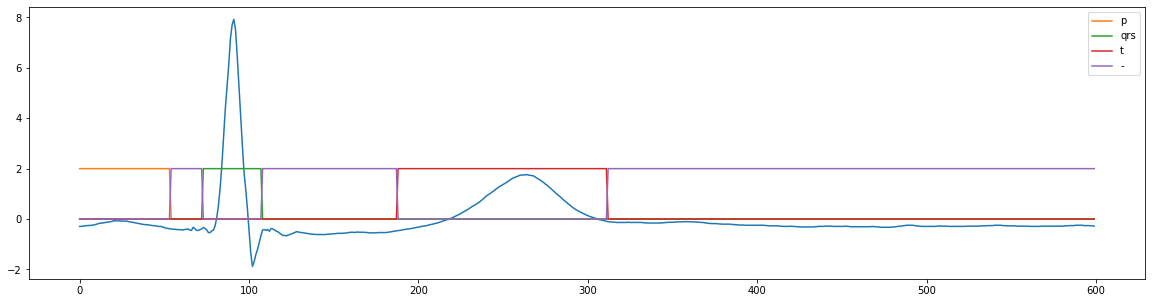

In [14]:
ii_file = os.listdir('/content/drive/MyDrive/Colab Notebooks/npy')
print(len(ii_file))

ii_file_df = pd.DataFrame([[filename.split('_')[0],filename]for filename in ii_file],columns=['pid','filename'])
ii_file_df = ii_file_df.sort_values(['pid','filename'])
ii_file_df['filepath'] = ii_file_df.filename.apply(lambda x : os.path.join('/content/drive/MyDrive/Colab Notebooks/npy',x))
ii_file_df = ii_file_df[ii_file_df.pid!='.ipynb']


seg_ii = np.load(os.path.join('/content/drive/MyDrive/Colab Notebooks/npy',ii_file_df.filename.tolist()[N]))


plt.figure(figsize=(20, 5))
plt.plot((seg_ii[0]-np.mean(seg_ii[0]))/np.std(seg_ii[0]))
plt.plot((seg_ii[1]*2),label='p')
plt.plot((seg_ii[2]*2),label='qrs')
plt.plot((seg_ii[3]*2),label='t')
plt.plot(seg_ii[4]*2,label='-')
plt.legend()
print(N)
N+=1

In [15]:
## hyper parameter
# device = 'cuda:1'
device = 'cuda:0'
class_n = 2
total_epoch = 300

lr = 0.001
batch_size = 256

In [16]:
pid_value = list(set(ii_file_df.pid.tolist()))
shuffle(pid_value)

tr_pid_ii = pid_value[:int(len(pid_value)*(3/4))]
vd_pid_ii = pid_value[int(len(pid_value)*(3/4)):]

tr_file_ii = ii_file_df.query("pid in @tr_pid_ii")
vd_file_ii = ii_file_df.query("pid in @vd_pid_ii")

#tr_file_ii['filepath'] = tr_file_ii['filepath'].map(lambda x: x.replace('../', '/content/ii/'))
#vd_file_ii['filepath'] = vd_file_ii['filepath'].map(lambda x: x.replace('../', '/content/ii/'))

###


tr_data_ii = seg_data(tr_file_ii)
vd_data_ii = seg_data(vd_file_ii)

tr_loader_ii = DataLoader(tr_data_ii,batch_size=batch_size,shuffle=True,drop_last=True)
vd_loader_ii = DataLoader(vd_data_ii,batch_size=batch_size)

In [17]:
tr_file_ii

,pid,filename,filepath
1380,1,1_0.npy,/content/drive/MyDrive/Colab Notebooks/npy/1_0...
1408,1,1_105.npy,/content/drive/MyDrive/Colab Notebooks/npy/1_1...
1409,1,1_107.npy,/content/drive/MyDrive/Colab Notebooks/npy/1_1...
1410,1,1_110.npy,/content/drive/MyDrive/Colab Notebooks/npy/1_1...
1411,1,1_114.npy,/content/drive/MyDrive/Colab Notebooks/npy/1_1...
...,...,...,...
1266,7,7_86.npy,/content/drive/MyDrive/Colab Notebooks/npy/7_8...
1267,7,7_89.npy,/content/drive/MyDrive/Colab Notebooks/npy/7_8...
1250,7,7_9.npy,/content/drive/MyDrive/Colab Notebooks/npy/7_9...
1268,7,7_93.npy,/content/drive/MyDrive/Colab Notebooks/npy/7_9...


In [18]:
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR,ReduceLROnPlateau

model = Unet_1D(4,6).double().to(device)
optim = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optim,'min',patience=10,factor=0.8,min_lr=1e-8)
loss_f = torch.nn.BCEWithLogitsLoss()

In [19]:
# tr_output_list = list()
#########################
#########################
train_loss = []
valid_loss = []
#########################
#########################

for epoch in range(total_epoch):
    model.train()
    tr_loss_ii = 0
    tr_output_ii = list()
    
    try:
      for idx,(X,y) in enumerate(tr_loader_ii):
          optim.zero_grad()
          
          y_pred_ii = model(X.to(device))
          loss_ii = loss_f(y_pred_ii,y.to(device))
          
          loss_ii.backward()
          optim.step()
          
          tr_loss_ii+=loss_ii.cpu().item()/len(tr_loader_ii)
          out_pred_ii = F.softmax(y_pred_ii,1).detach().cpu().numpy().argmax(axis=1)
          tr_output_ii.extend(list(out_pred_ii))

      if epoch %10 == 0:    
        print("------------- {} epoch-------------".format(epoch))
        print("Train loss : {:.3f}".format(tr_loss_ii))
      train_loss.append(tr_loss_ii)
    except:
      print("train error")
    
    vd_loss_ii = 0

    try:
      for idx,(X,y) in enumerate(vd_loader_ii):

          y_pred_ii = model(X.to(device))
          out_pred_ii = F.softmax(y_pred_ii,1).detach().cpu().numpy().argmax(axis=1)
          
          loss_ii = loss_f(y_pred_ii,y.to(device))
          vd_loss_ii+=loss_ii.cpu().item()/len(vd_loader_ii)

      
      if epoch %10 == 0:
        print("Valid loss : {:.3f}".format(vd_loss_ii))

      valid_loss.append(vd_loss_ii)
    except:
      print("test error")




------------- 0 epoch-------------
Train loss : 0.759
Valid loss : 0.739
------------- 1 epoch-------------
Train loss : 0.725
Valid loss : 0.713
------------- 2 epoch-------------
Train loss : 0.705
Valid loss : 0.699
------------- 3 epoch-------------
Train loss : 0.695
Valid loss : 0.693
------------- 4 epoch-------------
Train loss : 0.687
Valid loss : 0.682
------------- 5 epoch-------------
Train loss : 0.677
Valid loss : 0.672
------------- 6 epoch-------------
Train loss : 0.668
Valid loss : 0.661
------------- 7 epoch-------------
Train loss : 0.656
Valid loss : 0.653
------------- 8 epoch-------------
Train loss : 0.647
Valid loss : 0.643
------------- 9 epoch-------------
Train loss : 0.639
Valid loss : 0.636
------------- 10 epoch-------------
Train loss : 0.633
Valid loss : 0.631
------------- 11 epoch-------------
Train loss : 0.629
Valid loss : 0.626
------------- 12 epoch-------------
Train loss : 0.624
Valid loss : 0.623
------------- 13 epoch-------------
Train loss :

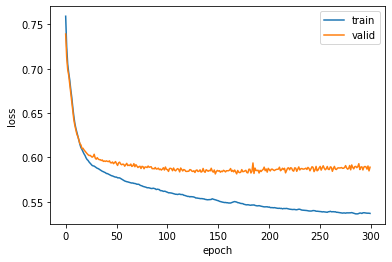

In [24]:
x = [_ for _ in range(total_epoch)]
import matplotlib.pyplot as plt

plt.plot(x, train_loss, label='train')
plt.plot(x, valid_loss, label='valid')
plt.legend(loc='upper right')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [17]:
vd_ecg_ii = list()
vd_label_ii = list()
vd_output_ii = list()

try:
    for idx,(X,y) in enumerate(vd_loader_ii):

        y_pred_ii = model(X.to(device))
        out_pred_ii = F.softmax(y_pred_ii,1).detach().cpu().numpy().argmax(axis=1)
    
        vd_output_ii.extend(list(out_pred_ii))
        vd_ecg_ii.extend(list(X.cpu().detach().numpy().squeeze(1)))
        vd_label_ii.extend(list(y.cpu().detach().numpy()))
except:
    print('file error')
    

In [18]:
from scipy.stats import mode
def output_sliding_voting(output,window=5):
    # window size must be odd number
    output = pd.Series(output).rolling(window).apply(lambda x : mode(x)[0][0]).fillna(method='bfill')
    return output.values

191


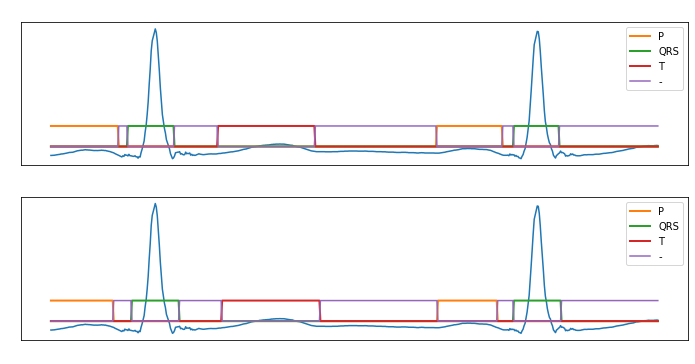

In [19]:
sample_n = np.random.randint(0,len(vd_ecg_ii))
print(sample_n)
ecg_ii = vd_ecg_ii[sample_n]
label = vd_label_ii[sample_n]

ii_out  = vd_output_ii[sample_n]
ii_out  = output_sliding_voting(ii_out ,7)

p = (ii_out  == 0)
N = (ii_out  == 1)
t = (ii_out  == 2)
r = (ii_out  == 3)


with plt.rc_context({'xtick.color':'white','ytick.color':'white'}):
    
    fig,axes = plt.subplots(2,1,figsize=(10,5))
    fig.tight_layout()
    
    axes[0].set_title("True",color='white')
    axes[0].plot(ecg_ii)
    axes[0].plot(label[0],label='P',linewidth=2)
    axes[0].legend(loc="upper right")
    axes[0].plot(label[1],label='QRS',linewidth=2)
    axes[0].plot(label[2],label='T',linewidth=2)
    axes[0].plot(label[3],label='-')
    axes[0].legend(loc="upper right")

    axes[1].set_title('Deep learnig Segmentation',color='white')
    axes[1].plot(ecg_ii)
    axes[1].plot(p,label='P',linewidth=2)
    axes[1].plot(N,label='QRS',linewidth=2)
    axes[1].plot(t,label='T',linewidth=2)
    axes[1].plot(r,label='-')
    axes[1].legend(loc="upper right")

In [21]:
### model accuracy 구현 ###

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
total_acc = []

for i in range(len(vd_label_ii)):
  in_ii = [0 for _ in range(600)]
  np.asarray(in_ii)

  label_ii = vd_label_ii[i]

  ii_out   = vd_output_ii[i] ## output
  ii_out   = output_sliding_voting(ii_out  ,7)

  p = (ii_out   == 0)
  N = (ii_out   == 1)
  t = (ii_out   == 2)
  r = (ii_out   == 3)

  for i in range(len(label_ii)):
    in_ii += label_ii[i]*i

  # print(accuracy_score(in_ii, out ))
  total_acc.append(accuracy_score(in_ii, ii_out  ))


print("model accuracy : ", sum(total_acc) / len(total_acc))

model accuracy :  0.9042786738351257
